In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Embedding, SimpleRNN

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load Datasets

In [ ]:
listSkinImages = []
listImagesPaths = []
for image_ in os.listdir("./skinImages"):
    if image_.endswith(".jpg") or image_.endswith(".jpeg") or image_.endswith(".png"):
        listSkinImages.append(image_)
        listImagesPaths.append(f"skinImages/{image_}")


dfSkinImages = pd.DataFrame({"imagePath":listImagesPaths,"image_id":listSkinImages})
dfSkinImages["image_id"] = dfSkinImages["image_id"].str.replace(".jpg","")
print(dfSkinImages.shape)
dfSkinImages.head()

# Visualize Images

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
for index, row in dfSkinImages.iterrows():
    imagePath = row['imagePath']
    image_ = plt.imread(imagePath)
    axes[index // 6, index % 6].imshow(image_)
    if(index >16):
        break    
plt.show()

# EDA

In [ ]:
dfLabels = pd.read_csv('HAM10000_metadata.csv')
dfLabels['label'] = dfLabels['dx']
dfLabels = dfLabels.replace({"label":{'akiec':0,'bcc': 1, 'bkl':2, 'df':3, 'nv':4, 'vasc':5, 'mel':6}})
dfLabels = pd.merge(dfLabels, dfSkinImages, on="image_id", how="left")
print(dfLabels.shape)
dfLabels.head()

In [ ]:
## We replace the null values with mean age
dfLabels['age'].fillna((dfLabels['age'].mean()), inplace = True)
print(dfLabels.isna().sum())

### Age Histogram

In [ ]:
dfLabels.hist('age', bins=30)

### Cancerous Classes

In [ ]:
dfClasses = pd.DataFrame(dfLabels['dx'].value_counts()).reset_index()
dfClasses.columns = ['dx','counts']
dfClasses.plot.bar(x = 'dx', y= 'counts')

### Image Resolution

In [ ]:
width  = image_.shape[1]
height = image_.shape[0]
print(f"Image width:  {width} pixels")
print(f"Image height: {height} pixels")

In [ ]:
listImages = []
listCancerLabel = []
for index, row in dfLabels.iterrows():
    imagePath = row['imagePath']
    cancerLabel = row['label']
    image = Image.open(imagePath)
    image = image.resize((32, 32))
    listImages.append(np.array(image).astype('float32')/255.0)             # Convert to 3D matrix
    listCancerLabel.append(cancerLabel)

npImages = np.array(listImages)
npCancerLabel = np.array(listCancerLabel)
print(len(npImages))

# Split Dataset into Training and Validations

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}
#---------------------------------------------------------------------------

def plotGraphs(history):
    trAcc   = history.history['accuracy']
    trLoss  = history.history['loss']
    valAcc  = history.history['val_accuracy']
    valLoss = history.history['val_loss']

    maxTrAcc = max(trAcc)
    maxTrAccEpoch = trAcc.index(maxTrAcc)
    maxValAcc = max(valAcc)
    minTrLoss = min(trLoss)
    minVaLoss = min(valLoss)
    listEpochs = [i for i in range(len(trAcc))]

    dfAcc = pd.DataFrame({"Training Accuracy": trAcc, "Validation Accuracy":valAcc })
    dfLoss = pd.DataFrame({"Training Loss":trLoss, "Validation Loss":valLoss })

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    sns.lineplot(data = dfAcc, ax = axes[0])
    sns.lineplot(data = dfLoss, ax = axes[1]) 
    sns.set_style("darkgrid")  
    plt.show()


datagen = ImageDataGenerator(rotation_range=45,
                             shear_range=0.2,
                             zoom_range = 0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode="reflect")

In [ ]:
# Split the data into training and testing sets
X_train , X_test , y_trainL , y_testL = train_test_split(npImages , npCancerLabel , test_size = 0.20 , random_state = 49)

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_trainL.shape}\ny_test shape: {y_testL.shape}')

y_train = to_categorical(y_trainL)
y_test = to_categorical(y_testL)

## Build Model

In [43]:
model_ = Sequential()
model_.add(Input(shape=[32, 32, 3]))
model_.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model_.add(MaxPool2D())
model_.add(BatchNormalization())
model_.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model_.add(MaxPool2D())
model_.add(BatchNormalization())

model_.add(Flatten())
model_.add(Dense(128, activation = 'relu', kernel_initializer='he_normal'))
model_.add(BatchNormalization())
model_.add(Dropout(rate=0.5))
model_.add(Dense(64, activation = 'relu', kernel_initializer='he_normal'))
model_.add(BatchNormalization())
model_.add(Dense(7, activation = 'softmax'))
model_.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model_.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                      

In [44]:
batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(X_test, y_test, batch_size=batch_size)


In [45]:
history = model_.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=len(X_test) // batch_size
)

Epoch 1/40
250/250 [==============================] - 8s 27ms/step - loss: 1.5847 - accuracy: 0.5004 - val_loss: 1.2298 - val_accuracy: 0.6492
Epoch 2/40
250/250 [==============================] - 20s 81ms/step - loss: 1.0392 - accuracy: 0.6596 - val_loss: 1.0733 - val_accuracy: 0.6542
Epoch 3/40
250/250 [==============================] - 17s 69ms/step - loss: 0.9181 - accuracy: 0.6846 - val_loss: 0.8462 - val_accuracy: 0.6976
Epoch 4/40
250/250 [==============================] - 17s 66ms/step - loss: 0.8545 - accuracy: 0.7009 - val_loss: 0.8373 - val_accuracy: 0.6951
Epoch 5/40
250/250 [==============================] - 19s 76ms/step - loss: 0.8187 - accuracy: 0.7049 - val_loss: 0.8357 - val_accuracy: 0.6981
Epoch 6/40
250/250 [==============================] - 18s 71ms/step - loss: 0.8115 - accuracy: 0.7055 - val_loss: 0.8212 - val_accuracy: 0.7051
Epoch 7/40
250/250 [==============================] - 20s 82ms/step - loss: 0.7872 - accuracy: 0.7129 - val_loss: 0.7911 - val_accuracy: 

In [ ]:
# datagen.fit(X_train)
# # Generate augmented data batches during training
# batch_size = 32
# train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
# #history = model_.fit(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train)/32, epochs=20)
# history = model_.fit(train_generator, y_train, epochs=20, validation_split=0.2)

In [ ]:
# history = model_.fit(X_train, y_train, epochs=20, validation_split=0.2)# 

### Plot Performance Graphs

Max Training Accuracy:  75.64
Min Training Loss:  0.65
Max Validation Accuracy:  75.1
Min Validation Loss:  0.66


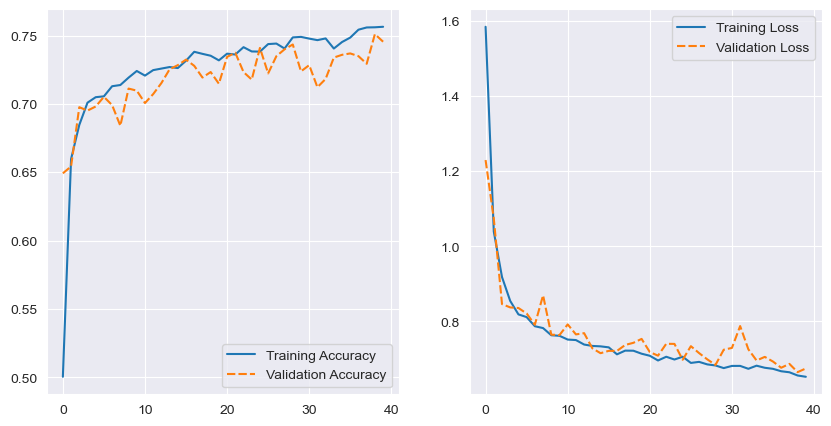

In [46]:
print("Max Training Accuracy: "   , round(max(history.history['accuracy'])*100,2))
print("Min Training Loss: "       , round(min(history.history['loss']),2))
print("Max Validation Accuracy: " , round(max(history.history['val_accuracy'])*100,2))
print("Min Validation Loss: "     , round(min(history.history['val_loss']),2))
plotGraphs(history)

# Model Evaluation

63/63 [==============================] - 0s 7ms/step - loss: 0.6673 - accuracy: 0.7564
Train Loss:  0.6014254093170166
Train Accuracy:  0.7724663019180298
--------------------
Test Loss:  0.667349636554718
Test Accuracy:  0.7563654780387878
63/63 [==============================] - 1s 9ms/step
[4, 6, 2, 1, 5, 0, 3]


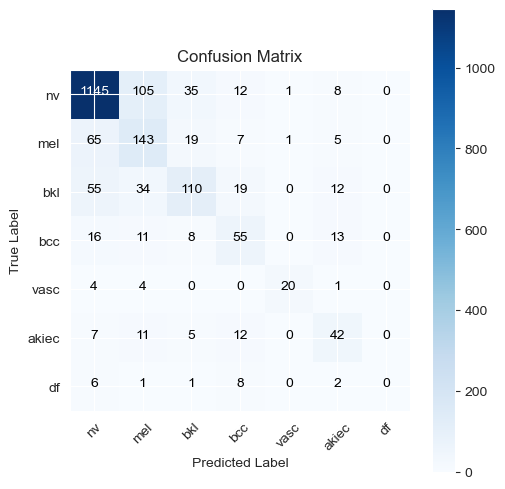

In [47]:
train_score = model_.evaluate(X_train, y_train, verbose= 1)
test_score = model_.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

y_true = np.array(y_test)
y_pred = model_.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)


# Confusion matrix
import itertools
cm =  confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
tick_labels = []
for key in classes:
    tick_labels.append(classes[key][0])
plt.xticks(tick_marks, tick_labels, rotation= 45)
plt.yticks(tick_marks, tick_labels)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()